In [118]:
# This script was written using Python 3.7

import pandas as pd # written using v. 0.24.2
import numpy as np # written using v. 1.16.2
import math # written using v. 1.1.0
import matplotlib.pyplot as plt # written using v. 3.1.1
import scipy.stats as ss # written using v. 1.3.2
import cmocean # written using v. 2.0

In [137]:
# import file with NFR and corresponding hydrographic information
# see Sharp16_15N2tracer_allrates_hydrograph_ReadMe.csv for full file description

infile = '..\Calculations\Sharp16_15N2tracer_allrates_hydrograph.csv' # This file contains all replicate rate measurements
df = pd.read_csv(infile)

# NFR_flag = flag for rate measurements (both FC and NFR)
#      - 0 = NFR value can be trusted
#      - 1 = analytical error occurred (e.g., 15N2 was not sufficiently enriched, PN on t=f filter was too low or high 
#            (outside linear range), autosampler/reduction column issues, etc.
#      - 2 = N2 fixation was below analytical detection limit

# If NFR_flag = 1, NFR and FC = -9999
# If NFR_flag = 2, NFR and FC = 0

# IrregInc_flag = Irregular incubation flag
#     - 0 = incubation is normal
#     - 1 = incubation conditions were manipulated (e.g., incubation was artificially dark, C was added,, or inc was 12 
#           instead of 24 hours)

print(df.shape)
df.columns

(379, 34)


Index(['UniqID', 'LocID', 'Sta', 'Depth_m', 'IrregInc_flag', 'IncLength_h',
       'IncVol_L', 'GlucoseAdd_ul', 'PCconc_uM', 'PCconc_err', 'PNconc_uM',
       'PNconc_err', 'FC_d', 'FC_LOD', 'NFR_nmolNLd', 'NFR_LOD', 'NFR_flag',
       'SeaFloor_Depth_m', 'Lat', 'Lon', 'Press_db', 'Sigmat_kgm3', 'Temp_C',
       'Sal', 'DO_umolkg', 'Fluor_mgm3', 'PO4_uM', 'PO4_err', 'NO2_uM',
       'NO2_err', 'NO3_uM', 'NO3_err', 'NH4_nM', 'NH4_err'],
      dtype='object')

In [138]:
# exclude rows where the incubation conditions were manipulated (i.e., did not represent the environment) and where
# the rate could not be calculated due to an analytical error
df = df[(df.IrregInc_flag == 0) & (df.NFR_flag !=1)]
print(df.shape)

(252, 34)


In [139]:
# select explanatory data for the model plus lat, lon, depth and LocID

X = df.drop(['UniqID','IncVol_L', 'Sta', 'IrregInc_flag', 'IncLength_h', 'GlucoseAdd_ul', 'PNconc_uM', 'PNconc_err', 'FC_d',
             'FC_LOD', 'NFR_LOD', 'NFR_flag', 'PO4_err', 'NO2_uM', 'NO2_err', 'NO3_err', 'NH4_nM', 'NH4_err', 'PCconc_err',
             'Press_db','Sigmat_kgm3', 'DO_umolkg','PO4_uM','NO3_uM','Sal','NFR_nmolNLd'], axis = 1).dropna()

print(np.shape(X))
X.head()

(252, 8)


,LocID,Depth_m,PCconc_uM,SeaFloor_Depth_m,Lat,Lon,Temp_C,Fluor_mgm3
0,1,0.93,7.089495,-1260,37.664668,-73.995213,26.766684,0.588138
1,1,0.93,7.089495,-1260,37.664668,-73.995213,26.766684,0.588138
2,1,0.93,7.089495,-1260,37.664668,-73.995213,26.766684,0.588138
3,2,35.37,11.565498,-1260,37.664647,-73.995540,15.049992,2.362376
4,2,35.37,11.565498,-1260,37.664647,-73.995540,15.049992,2.362376


In [140]:
# read in compiled, binned satellite data

infile = '..\Calculations\compiledseasfcdata_8daymean_2016Aug12to19_onetwentiethdegreegrid.csv'
satdf = pd.read_csv(infile)
satdf = satdf.dropna()
satdf.head()

,Lat,Lon,SeafloorDepth_m,Temp_c,Chl_mgm3,PCconc_uM
0,33.025,-78.975,-15.888889,30.514999,0.995067,15.605483
1,33.025,-78.925,-16.000000,30.334999,0.903461,14.692986
2,33.025,-78.875,-16.222222,30.597499,0.812825,14.201329
3,33.025,-78.825,-19.333333,30.639999,0.718290,12.964360
4,33.025,-78.775,-23.222222,30.639999,0.680952,12.343563


In [141]:
# compare smoothed satellite data with in situ (training) data
# define:  x_meas (CTD parameter), x_sat (satellite parameter), and title (plot title)


def compare():
    insitudata = []
    satdata = []
    d = 1 # number of decimals in lat/lon
    
    # match satellite data to in situ data
    for i in X.LocID[X.Depth_m < 5].unique():
        insitu = np.mean(x_meas[X.LocID == i])
        lat = np.round(np.mean(X.Lat[X.LocID == i]), decimals = d)
        lon = np.round(np.mean(X.Lon[X.LocID == i]), decimals = d)
        sat = np.mean(x_sat[(np.round(satdf.Lat, decimals = d) == lat) & (np.round(satdf.Lon, decimals = d) == lon)])
        insitudata.append('%f' % insitu)
        satdata.append('%f' % sat)
    data = pd.DataFrame({'insitu': insitudata, 'sat': satdata}, dtype = float).dropna()

    # plot in situ vs satellite data
    fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 100)
    plt.scatter(data.insitu,data.sat, color = 'k')
    plt.plot(data.insitu,data.insitu, color = 'r', label = 'one-to-one line')
    slope, intercept, r_value, p_value, std_err = ss.linregress(data.insitu,data.sat)
    y_pred = (slope*data.insitu) + intercept
    plt.plot(data.insitu, y_pred, 'k--', label = 'linear fit')
    plt.legend()
    plt.xlabel('In situ data')
    plt.ylabel('Satellite-derived data')
    plt.title(title)
    print("slope: %f, intercept: %f, r2: %f, p_value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.725405, intercept: 8.237306, r2: 0.856624, p_value: 0.000000


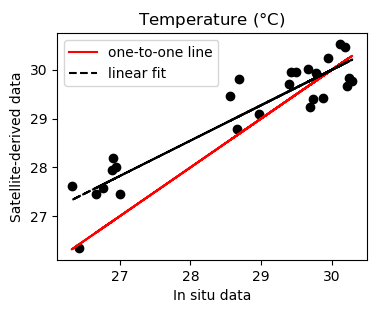

In [142]:
x_meas = X.Temp_C
x_sat = satdf.Temp_c
title = "Temperature ($\degree$C)"

compare()

slope: 0.269284, intercept: 3.822948, r2: 0.248915, p_value: 0.009473


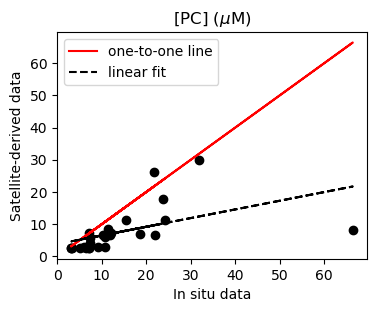

In [143]:
x_meas = df.PCconc_uM
x_sat = satdf.PCconc_uM
title = "[PC] ($\mu$M)"

compare()

slope: 1.419700, intercept: -0.535446, r2: 0.773447, p_value: 0.000000


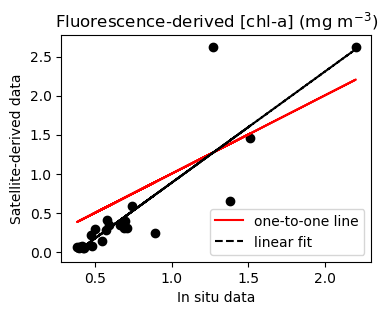

In [144]:
x_meas = X.Fluor_mgm3
x_sat = satdf.Chl_mgm3
title = "Fluorescence-derived [chl-a] (mg m$^{-3}$)"

compare()

slope: 0.999769, intercept: 2.520548, r2: 0.999935, p_value: 0.000000


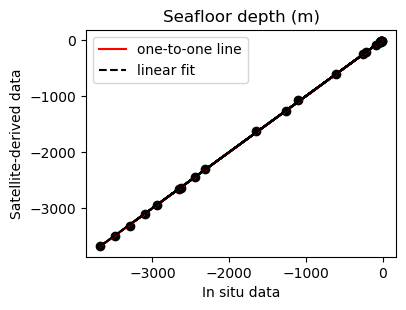

In [146]:
x_meas = X.SeaFloor_Depth_m
x_sat = satdf.SeafloorDepth_m
title = "Seafloor depth (m)"

compare()